Link Colab : https://colab.research.google.com/drive/1nBStdF29da5obuzm5RP0vjcOMhHtb1qD?usp=sharing

In [ ]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#read dataset
df = pd.read_csv('Data_Tanaman_Padi_Sumatera_version_1.csv')
df.tail()

,Provinsi,Tahun,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata
219,Lampung,2016,3831923.00,390799.00,2317.6,79.40,26.45
220,Lampung,2017,4090654.00,396559.00,1825.1,77.04,26.36
221,Lampung,2018,2488641.91,511940.93,1385.8,76.05,25.50
222,Lampung,2019,2164089.33,464103.42,1706.4,78.03,27.23
223,Lampung,2020,2604913.29,545149.05,2211.3,75.80,24.58


In [ ]:
#menambahkan kolom produktivitas dari hasil produksi dibagi luas panen
df['Produktivitas'] = df['Produksi'] / df['Luas Panen']

In [ ]:
#melihat info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Provinsi        224 non-null    object 
 1   Tahun           224 non-null    int64  
 2   Produksi        224 non-null    float64
 3   Luas Panen      224 non-null    float64
 4   Curah hujan     224 non-null    float64
 5   Kelembapan      224 non-null    float64
 6   Suhu rata-rata  224 non-null    float64
 7   Produktivitas   224 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 14.1+ KB


In [ ]:
df.isnull().sum()

Provinsi          0
Tahun             0
Produksi          0
Luas Panen        0
Curah hujan       0
Kelembapan        0
Suhu rata-rata    0
Produktivitas     0
dtype: int64

In [ ]:
#melihat ringkasan statistik dari data
df.describe()

,Tahun,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata,Produktivitas
count,224.000000,2.240000e+02,224.000000,224.000000,224.000000,224.000000,224.000000
mean,2006.500000,1.679701e+06,374349.966920,2452.490759,80.948705,26.801964,4.370405
std,8.095838,1.161387e+06,232751.161987,1031.972625,4.878680,1.197041,1.478052
min,1993.000000,4.293800e+04,63142.040000,222.500000,54.200000,22.190000,0.315310
25%,1999.750000,5.488570e+05,146919.500000,1703.525000,78.975000,26.177500,3.661188
50%,2006.500000,1.667773e+06,373551.500000,2315.700000,82.375000,26.730000,4.142801
75%,2013.250000,2.436851e+06,514570.250000,3039.700000,84.000000,27.200000,4.659973
max,2020.000000,4.881089e+06,872737.000000,5522.000000,90.600000,29.850000,12.658375


Rata-rata produktivitas padi di 8 provinsi selama 27 tahun adalah 4.370405 ton/ha. Rata-rata hasil panen adalah 1.679.700.887 ton dengan hasil terendah 42.938 ton dan tertinggi 4.881.089 ton. Rata-rata luas lahan pertanian adalah 37.433.450 hektar.

Dari deskripsi data di atas, dapat dilihat bahwa nilai mean dan median dari masing-masing atribut tidak jauh berbeda. Sehingga dapat dikatakan bahwa data tersebut berdistribusi normal.

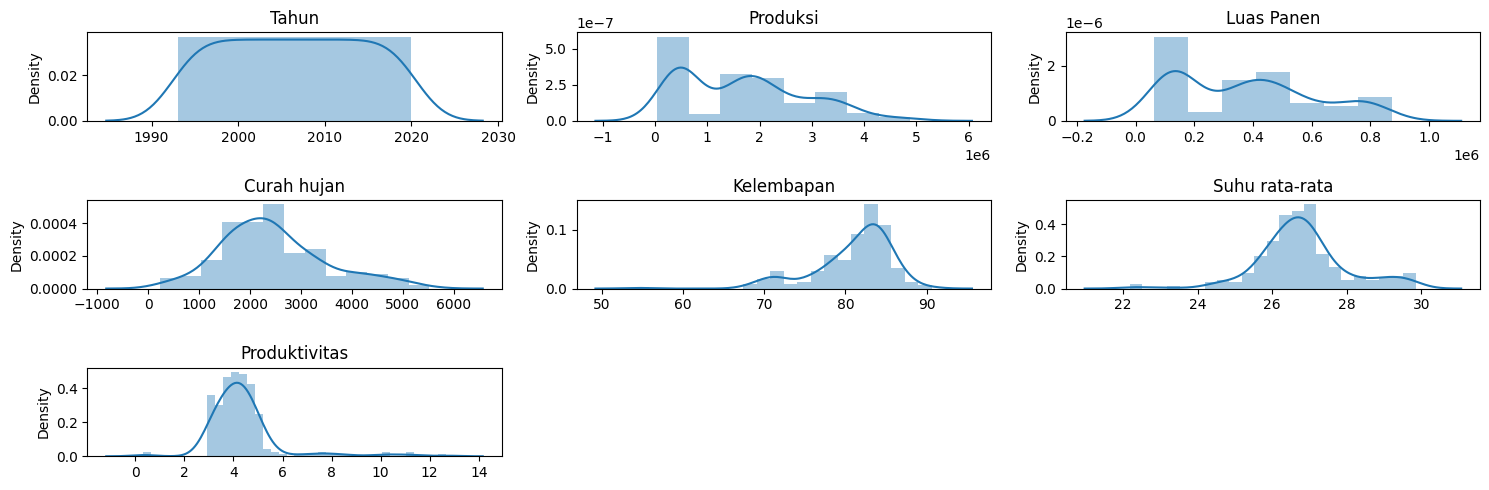

In [ ]:
#melihat distribusi nilai
plt.figure(figsize=(15,5))
axes = 1

for i in df.select_dtypes(exclude='object'):
    ax = plt.subplot(3,3,axes)
    sns.distplot(x = df[i])
    ax.set_title(i)
    axes += 1

plt.tight_layout()

Terlihat bahwa data berdistribusi normal

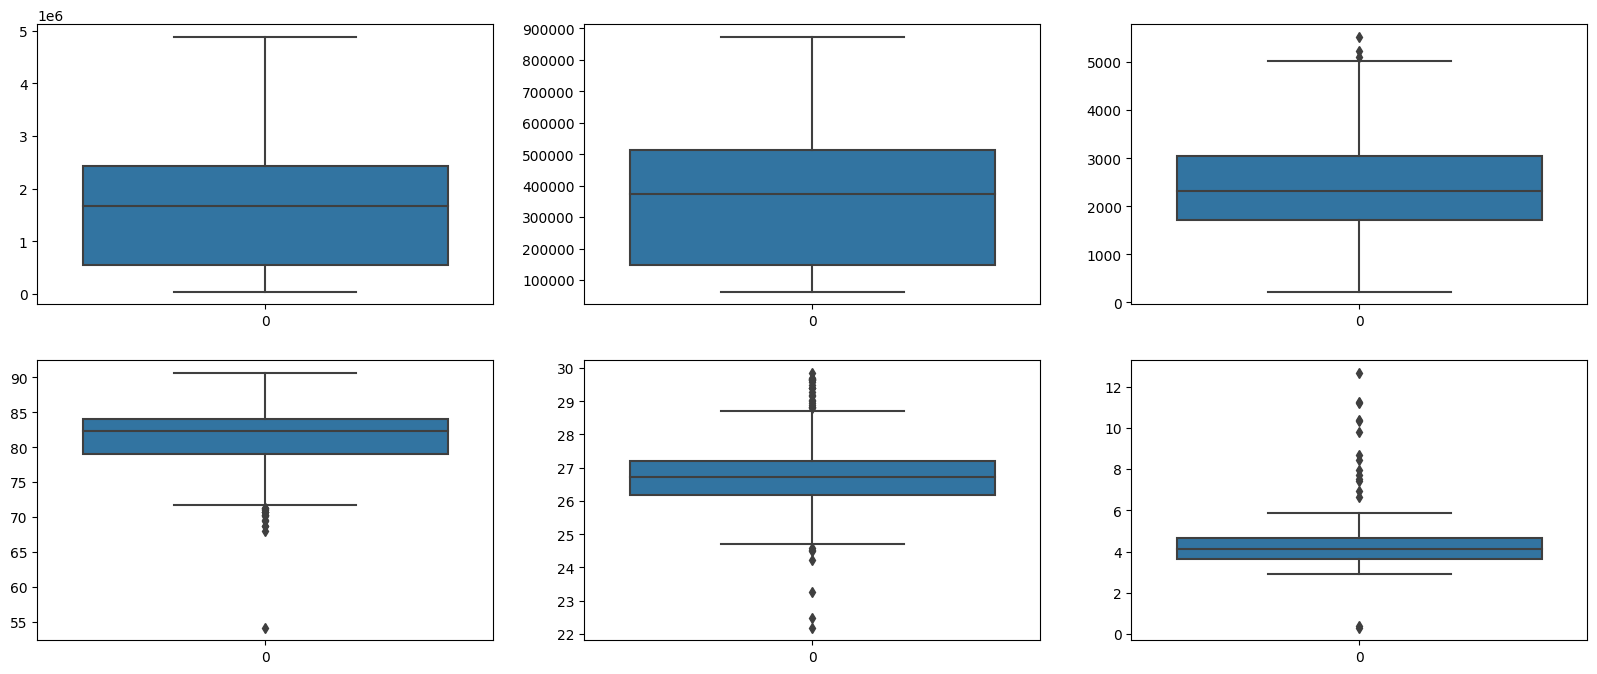

In [ ]:
#boxplot
plt.figure(figsize=(20,8))
axes = 1
for i in df.select_dtypes(include='float'):
    plt.subplot(2,3,axes)
    sns.boxplot(df[i])
    axes += 1

Terlihat terdapat beberapa outlier pada data

In [ ]:
#korelasi antar kolom
df.corr()

,Tahun,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata,Produktivitas
Tahun,1.000000,0.182527,-0.045951,-0.047645,-0.033474,0.004923,0.517904
Produksi,0.182527,1.000000,0.905622,-0.042129,-0.052316,0.041160,0.491524
Luas Panen,-0.045951,0.905622,1.000000,-0.092975,-0.061121,0.115726,0.127422
Curah hujan,-0.047645,-0.042129,-0.092975,1.000000,0.056466,-0.228699,0.122263
Kelembapan,-0.033474,-0.052316,-0.061121,0.056466,1.000000,-0.407799,-0.011869
Suhu rata-rata,0.004923,0.041160,0.115726,-0.228699,-0.407799,1.000000,-0.201093
Produktivitas,0.517904,0.491524,0.127422,0.122263,-0.011869,-0.201093,1.000000


Text(0.5, 1.0, 'Heatmap')

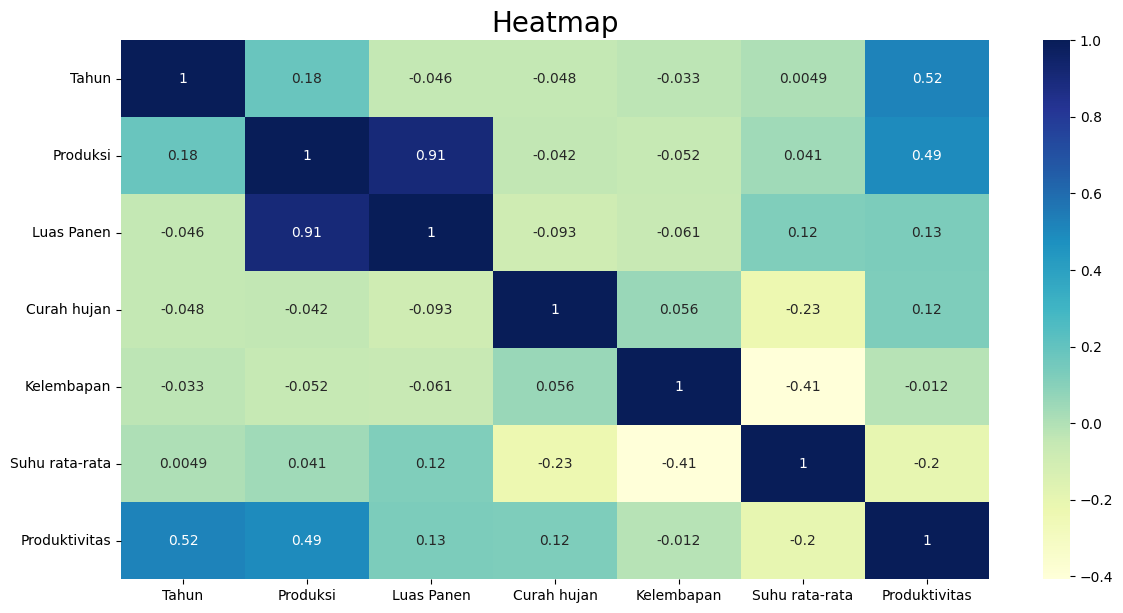

In [ ]:
#korelasi antar kolom dengan heatmap
plt.figure(figsize=(14,7))
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot=True, cmap='YlGnBu')
plt.title('Heatmap', fontsize=20)

##Output:

Produktivitas berkolerasi positif terhadap produksi, luas panen, dan curah hujan, yang berarti bahwa ketika nilai variabel independen tersebut semakin besar, maka produksi juga akan meningkat, meskipun mungkin tidak signifikan. <br>

Produktivitas berkolerasi negatif terhadap kelembapan dan suhu rata-rata, yang berarti ketika kedua variabel tersebut semakin kecil, maka produktivitas akan semakin meningkat (pergerakan grafik bergerak terbalik), meskipun hubungannya tidak terlalu kuat.


In [ ]:
#membersihkan data dari outlier dengan interquartile range
df_clean  = pd.DataFrame()

for i in df.select_dtypes(include='float'):
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1

    filter = (df[i] >= Q1 - 1.5 * IQR) & (df[i] <= Q3 + 1.5 *IQR)

    df_clean[i] = df[i].loc[filter]

In [ ]:
#mengisi nilai yang hilang (missing values) dengan nilai-nilai yang dihasilkan dari proses interpolasi
df_clean = df_clean.interpolate()

In [ ]:
#memilih variabel x dan y
x = df[['Produksi','Luas Panen', 'Curah hujan', 'Kelembapan', 'Suhu rata-rata']]
y = df['Produktivitas']

In [ ]:
#normalisasi
mms = MinMaxScaler()
normal_x = mms.fit_transform(x)
x = pd.DataFrame(normal_x, columns=x.columns)

In [ ]:
#membagi data menjadi set pelatihan dan pengujian
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=64)

In [ ]:
#melatih model
lr = LinearRegression(fit_intercept=True, copy_X=True, positive=False)
rf = RandomForestRegressor()
xgb = XGBRegressor()
svm = SVR(kernel= 'rbf', gamma= 1,C= 100, degree= 2, epsilon= 0.1)

In [ ]:
#hyperparameter tuning untuk mendapetkan parameter yang paling optimal
param_lr = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

param_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': np.logspace(-4, 0, 5),
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5]
}

random_search = RandomizedSearchCV(svm, param_distributions=param_svm, n_iter=10, cv=5, random_state=0, n_jobs=-1)
random_search.fit(x_train, y_train)

print(random_search.best_params_)

{'kernel': 'rbf', 'gamma': 1.0, 'epsilon': 0.1, 'degree': 2, 'C': 100}


In [ ]:
#melatih model regresi
lr.fit(x_train, y_train)
rf.fit(x_train, y_train)
xgb.fit(x_train, y_train)
svm.fit(x_train, y_train)

SVR(C=100, degree=2, gamma=1)

In [ ]:
#membuat prediksi model
lr_pred = lr.predict(x_test)
rf_pred = rf.predict(x_test)
xgb_pred = xgb.predict(x_test)
svm_pred = svm.predict(x_test)

In [ ]:
#menghitung metrik evaluasi

#r2 score
lr_r2 = r2_score(y_test,lr_pred)
rf_r2 = r2_score(y_test,rf_pred)
xgb_r2 = r2_score(y_test,xgb_pred)
svm_r2 = r2_score(y_test,svm_pred)

#rmse
lr_rmse = np.sqrt(mean_squared_error(y_test,lr_pred))
rf_rmse = np.sqrt(mean_squared_error(y_test,rf_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test,xgb_pred))
svm_rmse =np.sqrt(mean_squared_error(y_test,svm_pred))

#mae
lr_mae = mean_absolute_error(y_test,lr_pred)
rf_mae = mean_absolute_error(y_test,rf_pred)
xgb_mae = mean_absolute_error(y_test,xgb_pred)
svm_mae = mean_absolute_error(y_test,svm_pred)

In [ ]:
#menampilkan hasil evaluasi dari model
evaluation = pd.DataFrame()
evaluation['Model'] = ['LR','RF','XGB','SVM']
evaluation['R2'] = [lr_r2,rf_r2,xgb_r2,svm_r2]
evaluation['RMSE'] = [lr_rmse,rf_rmse,xgb_rmse,svm_rmse]
evaluation['MAE'] = [lr_mae,rf_mae,xgb_mae,svm_mae]

evaluation

,Model,R2,RMSE,MAE
0,LR,0.861369,0.397270,0.322761
1,RF,0.450465,0.790958,0.379371
2,XGB,0.696423,0.587882,0.301653
3,SVM,0.986013,0.126189,0.097994


##Output:
- Linear Regression: <br>
  R2 = 0.861 (mendekati 1). Artinya, 86,13% variasi dalam variabel dependen dijelaskan oleh model. <br>
  RMSE = 0.397. Artinya, rata-rata perbedaan antara nilai prediksi dan nilai sebenarnya sekitar 0.397.<br>
  MAE = 0.322. Artinya, rata-rata selisih absolut antara nilai prediksi dan nilai sebenarnya sekitar 0.322. <br>

- Random Forest: <br>
  R2 = 0.453. Artinya, 46,09% variasi dalam variabel dependen dijelaskan oleh model. <br>
  RMSE = 0.783. Artinya,rata-rata perbedaan antara nilai prediksi dan nilai sebenarnya sekitar 0.788.<br>
  MAE = 0.394. Artinya, rata-rata selisih absolut antara nilai prediksi dan nilai sebenarnya sekitar 0.374. <br>

- XGBoost: <br>
  R2 = 0.696. Artinya, 69,64% variasi dalam variabel dependen dijelaskan oleh model. <br>
  RMSE = 0.587. Artinya, rata-rata perbedaan antara nilai prediksi dan nilai sebenarnya sekitar 0.587.<br>
  MAE = 0.301. Artinya, rata-rata selisih absolut antara nilai prediksi dan nilai sebenarnya sekitar 0.301. <br>

- SVM: <br>
  R2 = 0.986 (mendekati 1). Artinya, 98,60% variasi dalam variabel dependen dijelaskan oleh model. <br>
  RMSE = 0.126. Artinya, rata-rata perbedaan antara nilai prediksi dan nilai sebenarnya sekitar 0.126.<br>
  MAE = 0.097. Artinya, rata-rata selisih absolut antara nilai prediksi dan nilai sebenarnya sekitar 0.097. <br>


In [ ]:
#membandingkan nilai aktual dengan nilai yang diprediksi oleh model SVM
hasil = pd.DataFrame()
hasil['Asli'] = y_test
hasil['Prediksi'] = svm_pred
hasil.sample(5)

,Asli,Prediksi
217,5.117782,4.948365
33,4.031627,4.118321
70,4.574760,4.588603
222,4.662946,4.715705
72,4.790873,4.843160


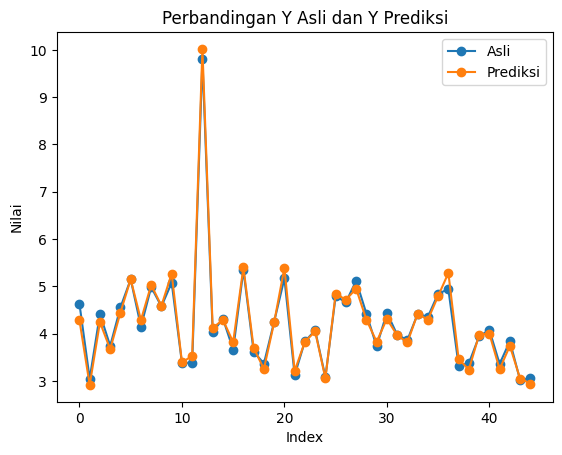

In [ ]:
# Plot garis
plt.plot(range(len(y_test)), y_test, label='Asli', marker='o')
plt.plot(range(len(svm_pred)), svm_pred, label='Prediksi', marker='o')

# Set label dan judul
plt.xlabel('Index')
plt.ylabel('Nilai')
plt.title('Perbandingan Y Asli dan Y Prediksi')
plt.legend()
plt.show()

##OUTPUT:
Berdasarkan  output hasil prediksi di atas, terlihat bahwa perbedaan antara nilai aktual dan nilai yang diprediksi oleh model SVM cukup kecil. Pada baris-baris tersebut hanya terdapat perbedaan beberapa persen dari nilai aktual. <br>
Dalam konteks ini, kecilnya perbedaan tersebut menunjukkan bahwa model SVM cenderung melakukan prediksi dengan baik.

In [ ]:
# Menggunakan fungsi groupby untuk mengelompokkan berdasarkan kolom 'Provinsi' dan menghitung rata-rata
result = df.groupby('Provinsi')['Produktivitas'].mean().reset_index()

# Menambahkan kolom baru
result['Batas Minimum Produktivitas Padi (Ton/Ha)'] = 8.0
result

# Menyoroti baris yang memenuhi kondisi (misalnya, Produktivitas >= Batas Minimum)
def highlight_condition(row):
    if row['Produktivitas'] >= row['Batas Minimum Produktivitas Padi (Ton/Ha)']:
        return ['background-color: purple'] * len(row)
    else:
        return [''] * len(row)

# Menetapkan gaya dengan menggunakan metode style
styled_result = result.style.apply(highlight_condition, axis=1)
styled_result

,Provinsi,Produktivitas,Batas Minimum Produktivitas Padi (Ton/Ha)
0,Aceh,4.712601,8.000000
1,Bengkulu,4.078857,8.000000
2,Jambi,3.837238,8.000000
3,Lampung,4.766108,8.000000
4,Riau,3.320930,8.000000
5,Sumatera Barat,5.168202,8.000000
6,Sumatera Selatan,4.182729,8.000000
7,Sumatera Utara,4.896575,8.000000


In [ ]:
# Menghitung rata-rata dari seluruh DataFrame
rata_rata_produktivitas = df['Produktivitas'].mean()

# Nilai minimum yang ditetapkan
batas_minimum = 8.0

# Membandingkan rata-rata dengan nilai minimum
di_atas_batas_minimum = rata_rata_produktivitas > batas_minimum

print(f"Rata-rata Produktivitas Padi di Pulau Sumatra : {rata_rata_produktivitas}")
print(f"Batas Minimum Produktivitas Padi (Ton/Ha) : {batas_minimum}")
print(f"Di Atas Batas Minimum : {di_atas_batas_minimum}")

Rata-rata Produktivitas Padi di Pulau Sumatra : 4.370405125753122
Batas Minimum Produktivitas Padi (Ton/Ha) : 8.0
Di Atas Batas Minimum : False


##OUTPUT:
Berdasarkan  output hasil di atas, terlihat Pulau Sumatra memiliki nilai produktivitas padi yang rendah. Nilai rata-rata produktivitas padi di Pulau Sumatra adalah 4.370405125753122, sementara batas minimum yang ditetapkan adalah 8.0. Oleh karena itu, dapat disimpulkan bahwa produktivitas padi di Pulau Sumatra masih di bawah batas minimum yang diharapkan, dan hal ini menjadi area potensial untuk perbaikan dalam meningkatkan produktivitas pertanian.

#KESIMPULAN

Berdasarkan hasil output di atas dapat disimpulkan bahwa:

1. **Prediksi Model SVM:**
   - Model SVM memberikan prediksi dengan perbedaan yang cukup kecil antara nilai aktual dan nilai yang diprediksi. Perbedaan tersebut hanya beberapa persen dari nilai aktual, menunjukkan bahwa model SVM cenderung melakukan prediksi dengan baik.

2. **Produktivitas Padi di Pulau Sumatra :**
   - Pulau Sumatra memiliki nilai produktivitas padi rendah. Dengan nilai rata-rata produktivitas sebesar 4.370405125753122 dan batas minimum 8.0, dapat disimpulkan bahwa produktivitas padi di Pulau Sumatra masih di bawah batas minimum yang diharapkan. Hal ini menunjukkan bahwa Pulau Sumatra merupakan area potensial untuk perbaikan dalam meningkatkan produktivitas pertanian.

Secara keseluruhan, hasil analisis menunjukkan adanya variasi produktivitas pertanian di Pulau Sumatra memerlukan perhatian khusus untuk peningkatan produktivitasnya.